ПО ОТДЕЛЬНСОТИ КАЖДАЯ МОДЕЛЬ CIFIR 10!!!!

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training With Cholesky...


100%|██████████| 782/782 [02:26<00:00,  5.33it/s]


Epoch 1, Accuracy: 43.32%


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 2, Accuracy: 49.75%


100%|██████████| 782/782 [02:24<00:00,  5.41it/s]


Epoch 3, Accuracy: 53.25%


100%|██████████| 782/782 [02:22<00:00,  5.48it/s]


Epoch 4, Accuracy: 56.20%


100%|██████████| 782/782 [02:23<00:00,  5.47it/s]


Epoch 5, Accuracy: 57.99%
Training Without Cholesky...


100%|██████████| 782/782 [00:24<00:00, 32.51it/s]


Epoch 1, Accuracy: 44.10%


100%|██████████| 782/782 [00:24<00:00, 32.33it/s]


Epoch 2, Accuracy: 49.68%


100%|██████████| 782/782 [00:24<00:00, 32.35it/s]


Epoch 3, Accuracy: 53.33%


100%|██████████| 782/782 [00:23<00:00, 32.93it/s]


Epoch 4, Accuracy: 55.77%


100%|██████████| 782/782 [00:24<00:00, 32.25it/s]


Epoch 5, Accuracy: 57.54%

--- Summary of Results ---
Average Accuracy (Cholesky): 52.10%
Average Accuracy (No Cholesky): 52.08%


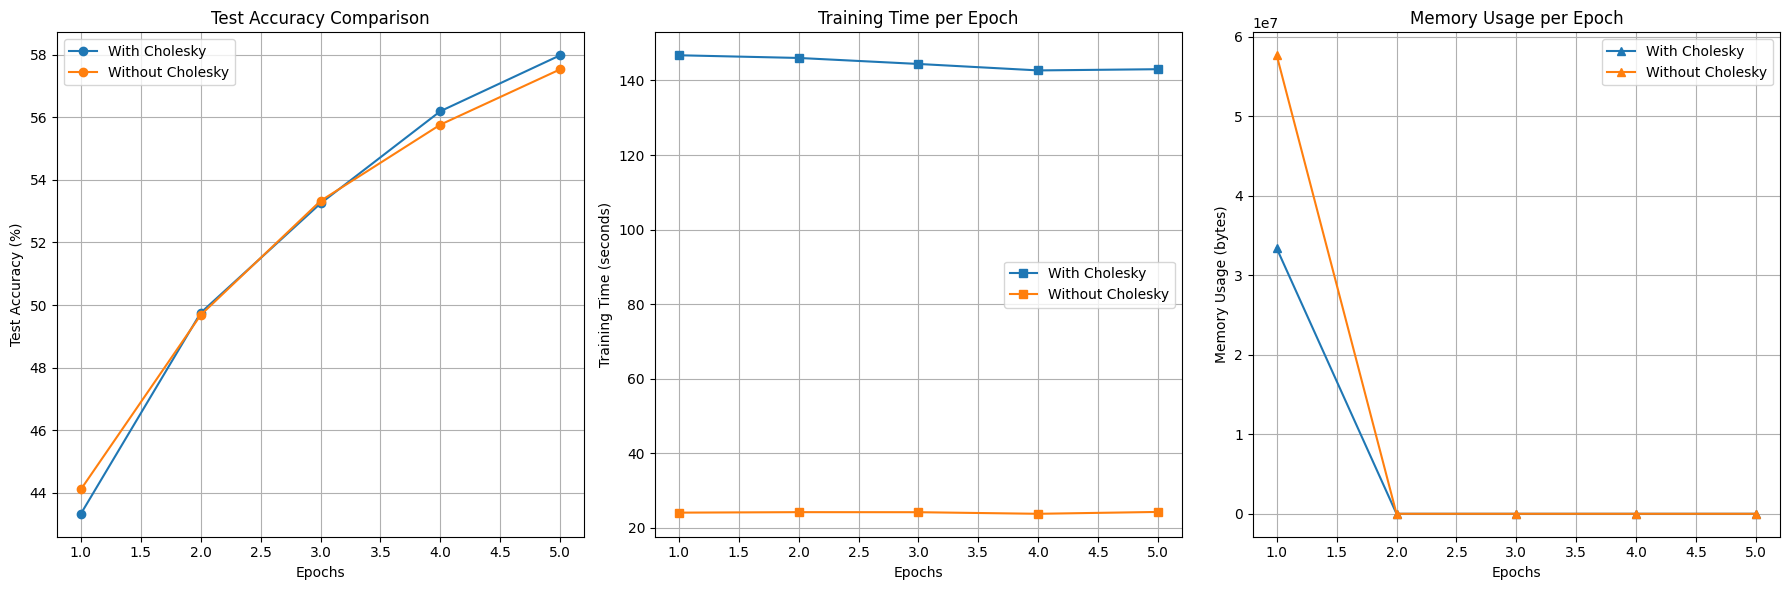

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer block with Cholesky decomposition
class TransformerBlockCholesky(nn.Module):
    def __init__(self, embed_dim, num_heads, epsilon=1e-6):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.epsilon = epsilon  # Small value to ensure positive-definiteness

    def forward(self, x):
        x2 = self.layernorm1(x)
        attn_output, attn_weights = self.attn(x2, x2, x2)
        attn_weights = self._regularize_attention_matrix(attn_weights)
        self._cholesky_decomposition(attn_weights)
        x = x + attn_output
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)
        return x

    def _regularize_attention_matrix(self, attn_weights):
        batch_size, seq_len, _ = attn_weights.size()
        identity = torch.eye(seq_len, device=attn_weights.device).unsqueeze(0).repeat(batch_size, 1, 1)
        return attn_weights + self.epsilon * identity

    def _cholesky_decomposition(self, x):
        try:
            torch.linalg.cholesky(x)
        except RuntimeError:
            torch.linalg.pinv(x)

# Transformer block without Cholesky
class TransformerBlockNoCholesky(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x2 = self.layernorm1(x)
        attn_output, _ = self.attn(x2, x2, x2)
        x = x + attn_output
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)
        return x

# Custom Vision Transformer
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, depth, num_classes, use_cholesky=True):
        super().__init__()
        self.use_cholesky = use_cholesky
        self.patch_size = patch_size
        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.blocks = nn.ModuleList([
            TransformerBlockCholesky(embed_dim, num_heads) if use_cholesky else TransformerBlockNoCholesky(embed_dim, num_heads)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)
        x = self.positional_encoding(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Function to train and evaluate the model
def train_and_evaluate(model, optimizer, train_loader, test_loader, model_name, num_epochs=5):
    train_times, train_memories, test_accuracies = [], [], []
    print(f"Training {model_name}...")
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        memory_before = get_memory_usage()

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        memory_after = get_memory_usage()

        # Evaluate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total

        train_times.append(end_time - start_time)
        train_memories.append(memory_after - memory_before)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}, Accuracy: {test_accuracy:.2f}%")

    return train_times, train_memories, test_accuracies

# Prepare data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_loader = DataLoader(datasets.CIFAR10('./data', train=True, download=True, transform=transform), batch_size=64)
test_loader = DataLoader(datasets.CIFAR10('./data', train=False, download=True, transform=transform), batch_size=64)

# Initialize models
model_cholesky = CustomVisionTransformer(32, 8, 3, 256, 8, 6, 10, use_cholesky=True).to(device)
model_no_cholesky = CustomVisionTransformer(32, 8, 3, 256, 8, 6, 10, use_cholesky=False).to(device)

optimizer_cholesky = torch.optim.Adam(model_cholesky.parameters(), lr=1e-4)
optimizer_no_cholesky = torch.optim.Adam(model_no_cholesky.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Train models and gather results
times_cholesky, mem_cholesky, acc_cholesky = train_and_evaluate(model_cholesky, optimizer_cholesky, train_loader, test_loader, "With Cholesky")
times_no_cholesky, mem_no_cholesky, acc_no_cholesky = train_and_evaluate(model_no_cholesky, optimizer_no_cholesky, train_loader, test_loader, "Without Cholesky")

# Summary and visualization
print("\n--- Summary of Results ---")
print(f"Average Accuracy (Cholesky): {sum(acc_cholesky) / len(acc_cholesky):.2f}%")
print(f"Average Accuracy (No Cholesky): {sum(acc_no_cholesky) / len(acc_no_cholesky):.2f}%")

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.plot(range(1, 6), acc_cholesky, label="With Cholesky")
plt.plot(range(1, 6), acc_no_cholesky, label="Without Cholesky")
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()


SVD1

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training with SVD:


100%|██████████| 782/782 [01:24<00:00,  9.24it/s]


Epoch 1, Test Accuracy: 43.8800%


100%|██████████| 782/782 [01:23<00:00,  9.40it/s]


Epoch 2, Test Accuracy: 49.1900%


100%|██████████| 782/782 [01:22<00:00,  9.50it/s]


Epoch 3, Test Accuracy: 52.9700%


100%|██████████| 782/782 [01:22<00:00,  9.46it/s]


Epoch 4, Test Accuracy: 54.6600%


100%|██████████| 782/782 [01:22<00:00,  9.53it/s]


Epoch 5, Test Accuracy: 56.9700%


100%|██████████| 782/782 [01:22<00:00,  9.52it/s]


Epoch 6, Test Accuracy: 60.0400%


100%|██████████| 782/782 [01:23<00:00,  9.41it/s]


Epoch 7, Test Accuracy: 61.6000%


100%|██████████| 782/782 [01:22<00:00,  9.52it/s]


Epoch 8, Test Accuracy: 61.9500%


100%|██████████| 782/782 [01:21<00:00,  9.55it/s]


Epoch 9, Test Accuracy: 63.0200%


100%|██████████| 782/782 [01:24<00:00,  9.26it/s]


Epoch 10, Test Accuracy: 63.5600%
Training without SVD:


100%|██████████| 782/782 [00:25<00:00, 30.61it/s]


Epoch 1, Test Accuracy: 43.5400%


100%|██████████| 782/782 [00:25<00:00, 31.19it/s]


Epoch 2, Test Accuracy: 47.9600%


100%|██████████| 782/782 [00:25<00:00, 30.80it/s]


Epoch 3, Test Accuracy: 52.8900%


100%|██████████| 782/782 [00:25<00:00, 30.78it/s]


Epoch 4, Test Accuracy: 54.1900%


100%|██████████| 782/782 [00:24<00:00, 31.50it/s]


Epoch 5, Test Accuracy: 56.9400%


100%|██████████| 782/782 [00:24<00:00, 31.64it/s]


Epoch 6, Test Accuracy: 58.7200%


100%|██████████| 782/782 [00:25<00:00, 31.00it/s]


Epoch 7, Test Accuracy: 60.4600%


100%|██████████| 782/782 [00:24<00:00, 31.35it/s]


Epoch 8, Test Accuracy: 61.0200%


100%|██████████| 782/782 [00:24<00:00, 32.02it/s]


Epoch 9, Test Accuracy: 63.1100%


100%|██████████| 782/782 [00:25<00:00, 30.99it/s]


Epoch 10, Test Accuracy: 63.6300%


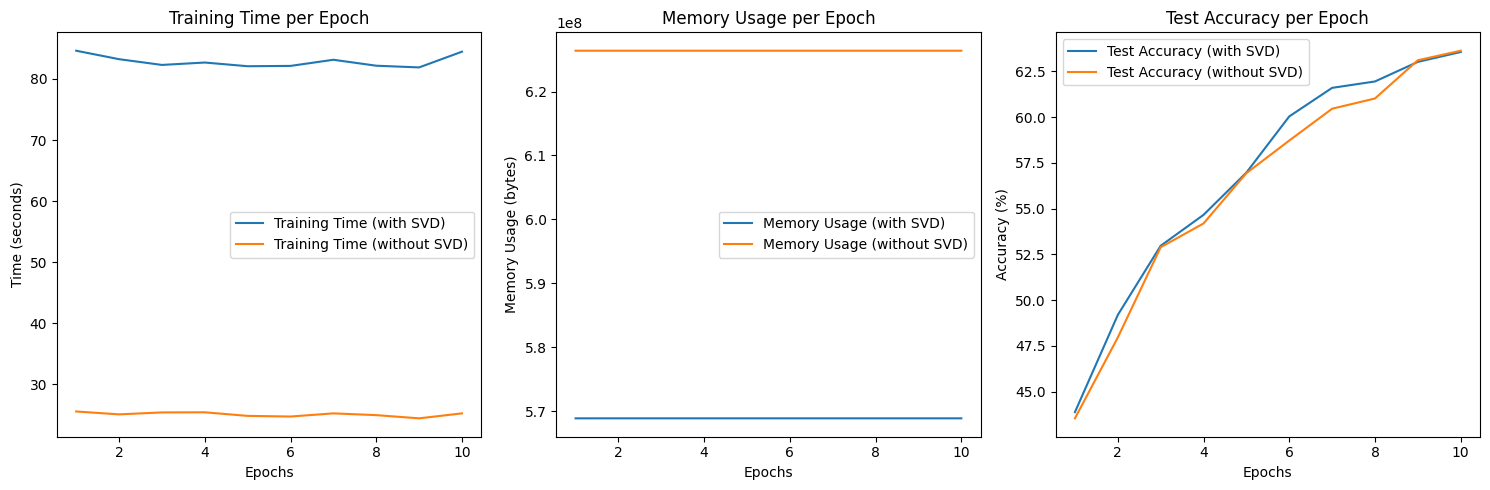

In [ ]:
# Full Code Implementation for Training Vision Transformer with and without SVD
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with SVD decomposition
class TransformerBlockSVD(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=50):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.rank = rank  # Rank for low-rank approximation

    def forward(self, x):
        x2 = self.layernorm1(x)
        attn_output, _ = self.attn(x2, x2, x2)  # Self-attention
        attn_output = self._svd_decomposition(attn_output)
        x = x + attn_output  # Adding the SVD-decoded attention output
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def _svd_decomposition(self, attn_output):
        # Low-rank SVD approximation
        batch_size, seq_len, embed_dim = attn_output.size()
        attn_matrix = attn_output.view(-1, embed_dim)  # Combine batch and sequence dimensions

        # Perform SVD
        U, S, V = torch.svd(attn_matrix)

        # Low-rank approximation
        rank = min(self.rank, len(S))
        U = U[:, :rank]
        S = torch.diag(S[:rank])
        V = V[:, :rank]

        attn_output_reduced = torch.matmul(U, torch.matmul(S, V.T))

        # Reshape back to the attention output shape
        attn_output_reduced = attn_output_reduced.view(batch_size, seq_len, embed_dim)
        return attn_output_reduced

# Transformer block without SVD
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x2 = self.layernorm1(x)
        attn_output, _ = self.attn(x2, x2, x2)
        x = x + attn_output
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)
        return x

# Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].detach()

# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_heads, depth, num_classes, svd=False, rank=50):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        self.svd = svd
        self.embedding = nn.Linear(patch_size * patch_size * 3, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        # Transformer blocks
        if svd:
            self.blocks = nn.ModuleList([TransformerBlockSVD(embed_dim, num_heads, rank) for _ in range(depth)])
        else:
            self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(depth)])

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self._create_patches(x)
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.fc(x)

    def _create_patches(self, x):
        B, C, H, W = x.shape
        p = self.patch_size
        x = x.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(B, C, -1, p * p)
        x = x.permute(0, 2, 1, 3).reshape(B, -1, p * p * C)
        return x

# Dataset and Dataloaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

# Train and Test Function
def train_model(model, optimizer, epochs=10):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    train_times = []
    train_memories = []
    accuracies = []
    for epoch in range(epochs):
        start_time = time.time()
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        train_times.append(time.time() - start_time)
        train_memories.append(get_memory_usage())

        # Evaluate accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        test_accuracy = 100 * correct / total
        accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Accuracy: {test_accuracy:.4f}%")
    return train_times, train_memories, accuracies

# Initialize and train both models
model_svd = VisionTransformer(32, 8, 256, 8, 6, 10, svd=True).to(device)
optimizer_svd = torch.optim.Adam(model_svd.parameters(), lr=1e-4)

model_no_svd = VisionTransformer(32, 8, 256, 8, 6, 10, svd=False).to(device)
optimizer_no_svd = torch.optim.Adam(model_no_svd.parameters(), lr=1e-4)

print("Training with SVD:")
train_times_svd, train_memories_svd, test_accuracies_svd = train_model(model_svd, optimizer_svd)

print("Training without SVD:")
train_times_no_svd, train_memories_no_svd, test_accuracies_no_svd = train_model(model_no_svd, optimizer_no_svd)

# Training time plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_times_svd, label="Training Time (with SVD)")
plt.plot(range(1, 11), train_times_no_svd, label="Training Time (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(range(1, 11), train_memories_svd, label="Memory Usage (with SVD)")
plt.plot(range(1, 11), train_memories_no_svd, label="Memory Usage (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(range(1, 11), test_accuracies_svd, label="Test Accuracy (with SVD)")
plt.plot(range(1, 11), test_accuracies_no_svd, label="Test Accuracy (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


### PCA


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch 10 Training (with PCA): 100%|██████████| 782/782 [00:24<00:00, 32.20it/s]


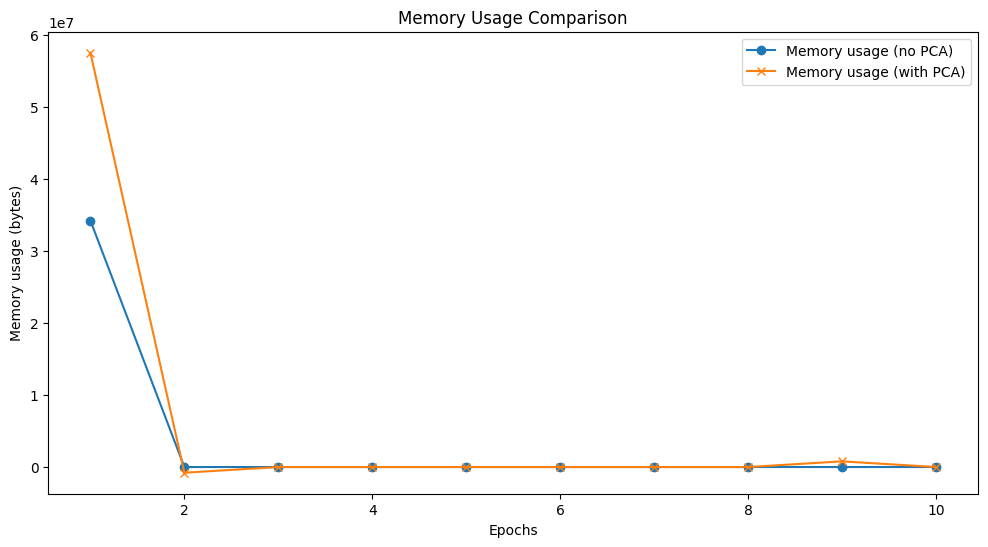

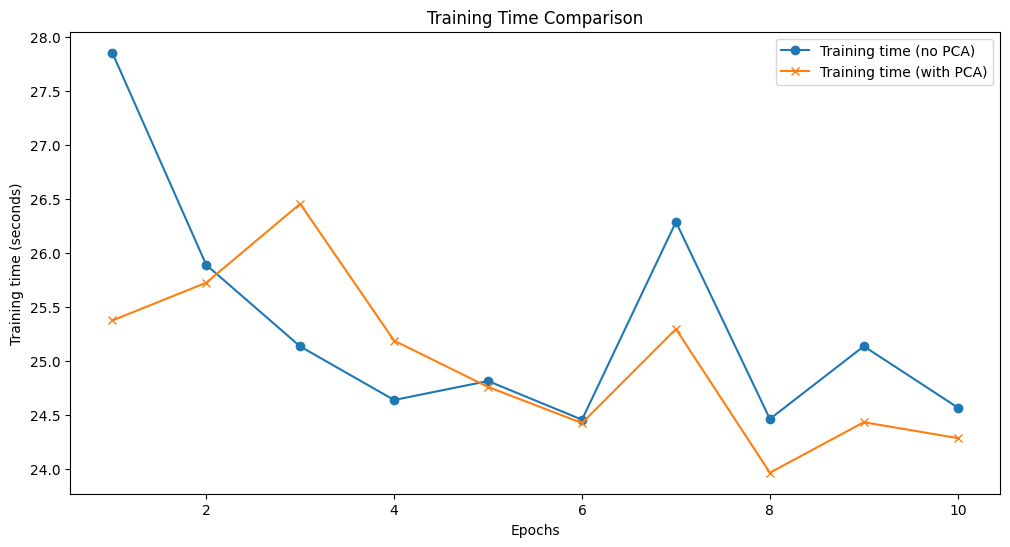

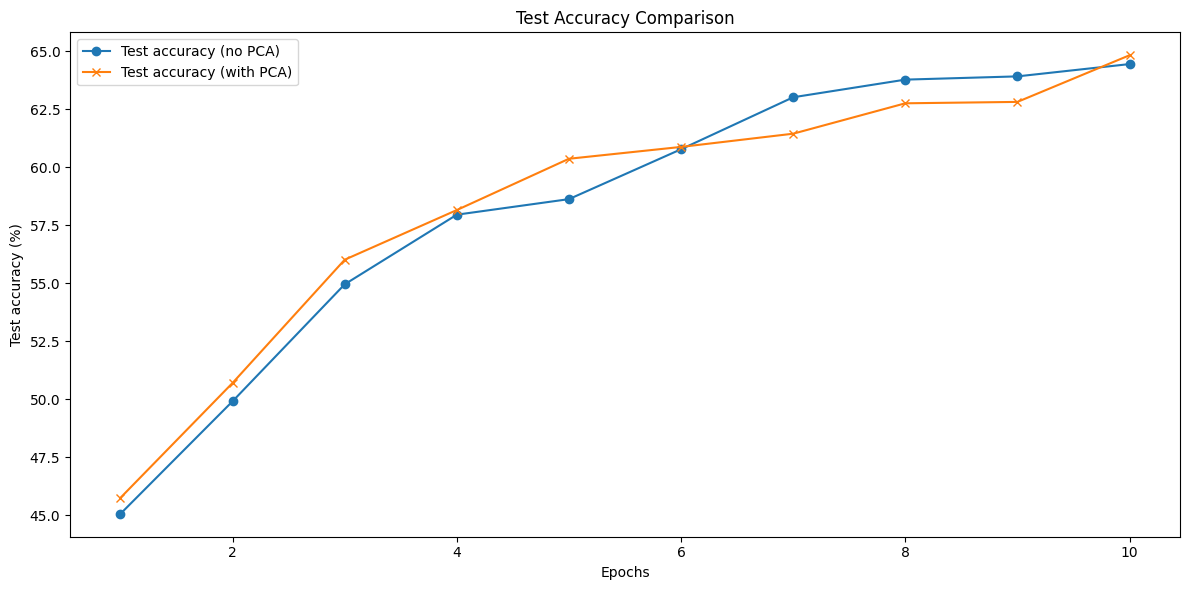

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
import math

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with PCA-based low-rank approximation
class TransformerBlockPCA(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=64):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.rank = rank  # Rank for low-rank approximation using PCA

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def pca_low_rank_approximation(self, attn_matrix):
        # Apply PCA with truncation for low-rank approximation
        pca = PCA(n_components=self.rank)
        attn_matrix = attn_matrix.cpu().numpy()  # Convert tensor to numpy
        attn_matrix_pca = pca.fit_transform(attn_matrix)  # Perform PCA
        attn_matrix_low_rank = pca.inverse_transform(attn_matrix_pca)  # Inverse transform to get low-rank approximation
        return torch.tensor(attn_matrix_low_rank).to(attn_matrix.device)  # Convert back to tensor

# Positional encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x should have shape [batch_size, seq_len, embed_dim]
        return x + self.pe[:, :x.size(1)]

# Main model with PCA-based low-rank approximation blocks and positional encoding
class CustomVisionTransformerPCA(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10, rank=64):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes
        self.rank = rank

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=(img_size // patch_size) ** 2)
        self.blocks = nn.ModuleList([TransformerBlockPCA(embed_dim, num_heads, rank) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)
        x = self.positional_encoding(x)  # Add positional encoding to the embedded patches

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without PCA-based low-rank approximation
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=(img_size // patch_size) ** 2)
        self.blocks = nn.ModuleList([TransformerBlockPCA(embed_dim, num_heads) for _ in range(depth)])  # Same block as above
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)
        x = self.positional_encoding(x)  # Add positional encoding to the embedded patches

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# The rest of the code remains the same for training and evaluation


# Load and prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize models and optimizers
model = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10).to(device)
model_pca = CustomVisionTransformerPCA(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10, rank=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_pca = torch.optim.Adam(model_pca.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_no_pca, train_times_with_pca = [], []
train_memories_no_pca, train_memories_with_pca = [], []
test_accuracies_no_pca, test_accuracies_with_pca = [], []

# Training models
for epoch in range(10):
    # Train model without PCA
    model.train()
    epoch_start_time_no_pca = time.time()
    epoch_start_mem_no_pca = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (no PCA)"):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    epoch_end_time_no_pca = time.time()
    epoch_end_mem_no_pca = get_memory_usage()

    train_times_no_pca.append(epoch_end_time_no_pca - epoch_start_time_no_pca)
    train_memories_no_pca.append(epoch_end_mem_no_pca - epoch_start_mem_no_pca)

    # Test accuracy for model without PCA
    model.eval()
    correct_no_pca, total_no_pca = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_no_pca += (predicted == labels).sum().item()

            total_no_pca += labels.size(0)

    test_accuracy_no_pca = correct_no_pca / total_no_pca * 100
    test_accuracies_no_pca.append(test_accuracy_no_pca)

    # Train model with PCA
    model_pca.train()
    epoch_start_time_with_pca = time.time()
    epoch_start_mem_with_pca = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (with PCA)"):

        images, labels = images.to(device), labels.to(device)

        optimizer_pca.zero_grad()
        outputs_pca = model_pca(images)
        loss_pca = loss_fn(outputs_pca, labels)
        loss_pca.backward()
        optimizer_pca.step()

    epoch_end_time_with_pca = time.time()
    epoch_end_mem_with_pca = get_memory_usage()

    train_times_with_pca.append(epoch_end_time_with_pca - epoch_start_time_with_pca)
    train_memories_with_pca.append(epoch_end_mem_with_pca - epoch_start_mem_with_pca)

    # Test accuracy for model with PCA
    model_pca.eval()
    correct_with_pca, total_with_pca = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs_pca = model_pca(images)
            _, predicted = torch.max(outputs_pca, 1)
            correct_with_pca += (predicted == labels).sum().item()

            total_with_pca += labels.size(0)

    test_accuracy_with_pca = correct_with_pca / total_with_pca * 100
    test_accuracies_with_pca.append(test_accuracy_with_pca)

# Plotting results for comparison
epochs = list(range(1, 11))

# Memory usage plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_memories_no_pca, label="Memory usage (no PCA)", marker='o')
plt.plot(epochs, train_memories_with_pca, label="Memory usage (with PCA)", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Memory usage (bytes)")
plt.legend()
plt.title("Memory Usage Comparison")

# Training time plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_times_no_pca, label="Training time (no PCA)", marker='o')
plt.plot(epochs, train_times_with_pca, label="Training time (with PCA)", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Training time (seconds)")
plt.legend()
plt.title("Training Time Comparison")

# Test accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, test_accuracies_no_pca, label="Test accuracy (no PCA)", marker='o')
plt.plot(epochs, test_accuracies_with_pca, label="Test accuracy (with PCA)", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Test accuracy (%)")
plt.legend()
plt.title("Test Accuracy Comparison")

plt.tight_layout()
plt.show()
